# Bayesian Statistics Lab

In this hands-on lab, we continue our demonstration of "estimating the mass of a new fundamental particle".
We will generate multiple experiments, each giving a noisy measurement of the particle's mass, and sequentially update our posterior distribution after each experiment.
We will then discuss what we should do when new theoretical prior appears.

## Physical Setup (Brief Recap)

Let's update some notation from the notes.

We have a particle of **true mass** $m_\text{true}$, measured in TeV.
Each experiment yields an observed mass $m_\text{obs}$ with Gaussian noise:
\begin{align}
m_\text{obs} \;\sim\; \mathcal{N}(m_\text{true},\sigma_\text{expr}^2).
\end{align}
Here, $\sigma_\text{expr}$ is the detector resolution or statistical uncertainty.

We know that $m_\text{true}$ lies in some range $[2,8]$ TeV---our *initial theory* suggests it cannot be outside this window.
Hence, our **initial prior**:
\begin{align}
p(\theta) = 
\begin{cases}
1/(8 - 2), & 2 \le \theta \le 8, \\
0, & \text{otherwise}.
\end{cases}
\end{align}

Each measurement modifies our belief (the prior) into a **posterior** via Bayes' Theorem:
\begin{align}
p(m \mid m_{\text{obs}}) \propto p(m_{\text{obs}} \mid m) \, p(m).
\end{align}

Here, the **likelihood** $p(m_\text{obs} \mid m_\text{true})$ is given by the Gaussian formula:
\begin{align}
p(m_{\text{obs}} \mid m) = \frac{1}{\sqrt{2\pi}\,\sigma_\text{expr}} \exp\left[-\frac{(m_{\text{obs}}-m)^2}{2\sigma_\text{expr}^2}\right].
\end{align}

## Single Experiment Code (Grid Approximation)

Please rewrite the code in the class note into multiple functions that we can perform numerical experiments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# For reproducibility
np.random.seed(42)

In [3]:
# HANDSON: Define range for m (0 to 10 TeV)
ms = np.linspace(0, 10, 1001)

In [4]:
# HANDSON: Gaussian likelihood
def likelihood(x, x0, sigma):
    norm = 1.0 / (np.sqrt(2*np.pi) * sigma)
    return norm * np.exp(-0.5 * ((x-x0) / sigma)**2)

In [8]:
def run_expr(
    prior,        # Prior before updated by the experiment
    m_true,       # Suppose this is the true mass
    sigma_expr,   # Detector resolution
    seed = None,  # For reproducibility
):
    if seed is not None:
        np.random.seed(seed)

    # HANDSON: By running an experiment, we obtain a single measurement
    # You may use np.random.normal().
    m_obs = np.random.normal(loc = m_true)
    
    # HANDSON: Posterior ~ prior * likelihood
    like = likelihood(m_obs, ms, sigma_expr)
    unnorm_post = like * prior

    # HANDSON: Normalize the posterior
    norm = 1 / np.trapezoid(unnorm_post, ms)
    post = norm * unnorm_post

    return m_obs, post

In [9]:
# Uniform prior in [2, 8]
def prior0(ms, m_min=2, m_max=8):
    # HANDSON: Uniform in [2,8], zero outside
    return np.where((m_min <= ms) & (ms <= m_max), 1/(m_max-m_min), 0)

# Compute prior
prior = prior0(ms)

In [10]:
# Run a numerical experiment
m_true     = 3.6  # Set the groundtruth
sigma_expr = 1.0  # Detector resolution

m_obs, post = run_expr(prior, m_true, sigma_expr)

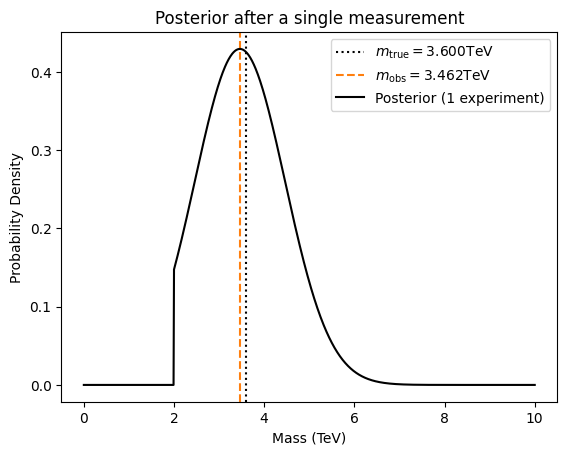

In [11]:
plt.axvline(m_true, ls=':',  color='k',  label=r"$m_\text{true}="+f"{m_true:.3f}$TeV")
plt.axvline(m_obs,  ls='--', color='C1', label=r"$m_\text{obs}= "+f"{m_obs:.3f}$TeV")
plt.plot(ms, post, 'k', label="Posterior (1 experiment)")
plt.title("Posterior after a single measurement")
plt.xlabel("Mass (TeV)")
plt.ylabel("Probability Density")
plt.legend()

## Multiple Experiments

Now we simulate $N$ experiments. Each experiment provides $(m_{\text{obs},i}, \sigma_i) = (m_{\text{obs},i}, \sigma_\text{expr})$.
We update our posterior step by step:
1. Start with the prior (initially uniform in $[2,8]$).
2. For each experiment $i$, multiply the current posterior by the new likelihood.
3. Normalize to get the updated posterior, which becomes the prior for the next experiment.

In [12]:
# For reproducibility
np.random.seed(42)

In [70]:
# HANDSON: Let's simulate multiple experiments
m_true     = 3.6  # Set the groundtruth
sigma_expr = 1.0  # Detector resolution
N          = 10   # Number of experiments

ms_obs = np.random.normal(loc = m_true, size = N) # Draw N samples from a normal distribution.  You may use np.random.normal().

print("Simulated experiment results:")
for i, m_obs in enumerate(ms_obs):
    print(f"\tExperiment {i+1}: observed mass = {m_obs:.3f} ± {sigma_expr:.3f}")

Simulated experiment results:
	Experiment 1: observed mass = 3.090 ± 1.000
	Experiment 2: observed mass = 3.330 ± 1.000
	Experiment 3: observed mass = 2.621 ± 1.000
	Experiment 4: observed mass = 3.156 ± 1.000
	Experiment 5: observed mass = 3.977 ± 1.000
	Experiment 6: observed mass = 4.357 ± 1.000
	Experiment 7: observed mass = 2.678 ± 1.000
	Experiment 8: observed mass = 4.470 ± 1.000
	Experiment 9: observed mass = 4.956 ± 1.000
	Experiment 10: observed mass = 4.013 ± 1.000


In [71]:
# HANDSON: compute the prior from prior0()

prior = prior0(ms)

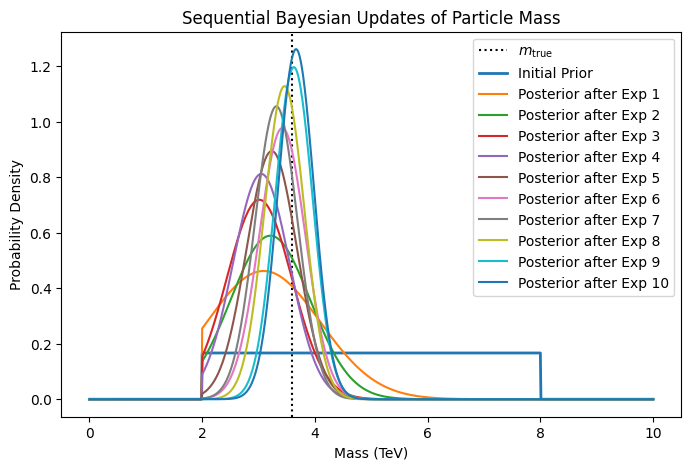

In [72]:
# Perform sequential Bayesian updates using the same grid approach

plt.figure(figsize=(8,5))
plt.axvline(m_true, color='k', ls=':', label=r'$m_\text{true}$')
plt.plot(ms, prior, label="Initial Prior", lw=2)

for i, m_obs in enumerate(ms_obs):
    # HANDSON: compute the posterior
    like = likelihood(m_obs, ms, sigma_expr)
    m_obs, post = ms_obs[i] , like * prior
    norm = 1 / np.trapezoid(post, ms)
    post = norm * post

    # Plot the posterior
    plt.plot(ms, post, label=f"Posterior after Exp {i+1}")

    # HANDSON: posterior becomes prior for next iteration
    prior = post

plt.title("Sequential Bayesian Updates of Particle Mass")
plt.xlabel("Mass (TeV)")
plt.ylabel("Probability Density")
plt.legend()

You will see each new experiment narrowing or shifting the distribution.

In [ ]:
# HANDSON:
# Try to increase `N` to, e.g, 100 and plot the posterior every 10 experiments.
# What do you see?

In [ ]:
# HANDSON:
# Try to change `m_true` to a value outside the theory, e.g., 1.5, and plot the posterior.
# What do you see?

In [ ]:
# HANDSON:
# Suppose now there are two theories, one suggests the mass range [2,8] TeV, one suggests the mass range [1,5] TeV.
# How would you take this new theory into account?
# Try implement your idea(s) and interpret the results.